In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from src.holt_winters import create_holt_winters_model
import os
import pickle

In [2]:
# Import and visualise dataset
df = pd.read_csv("datasets/nasa_requests_per_minute.csv")
df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time')

print(f"Dataset shape: {df.shape}")
print(f"Total entries in dataset: {len(df)}")
print(f"Date range: {df.index.min()} - {df.index.max()}")
print(f"First 5 rows: \n {df.head()}")

Dataset shape: (87015, 1)
Total entries in dataset: 87015
Date range: 1995-07-01 00:00:00 - 1995-08-31 23:59:00
First 5 rows: 
                      number_of_requests
time                                   
1995-07-01 00:00:00                  42
1995-07-01 00:01:00                  61
1995-07-01 00:02:00                  57
1995-07-01 00:03:00                  71
1995-07-01 00:04:00                  70


In [3]:
# Split dataset into train and test sets at 80/20 ratio
train_size = int(len(df) * 0.8)

train_dataset = df.iloc[:train_size]
test_dataset = df.iloc[train_size:]

print(f"Train data: {len(train_dataset)} entries")
print(f"Date range: {train_dataset.index.min()} - {train_dataset.index.max()} \n")
print(f"Test data: {len(test_dataset)} entries")
print(f"Date range: {test_dataset.index.min()} - {test_dataset.index.max()}")

Train data: 69612 entries
Date range: 1995-07-01 00:00:00 - 1995-08-19 21:56:00 

Test data: 17403 entries
Date range: 1995-08-19 21:57:00 - 1995-08-31 23:59:00


In [4]:
# Create and train model
holt_winters_model = create_holt_winters_model(seasonal_periods=1440)

print("Training model...")
holt_winters_model.fit(train_dataset['number_of_requests'].tolist())
print(f"Model training complete! \n Model fitted: {holt_winters_model.is_fitted()}")

Training model...


C:\Users\ajaylk\uni\fyp\code\tsf-models\venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Model training complete! 
 Model fitted: True


In [ ]:
# Reload module (what I used during development since changes were needed in wrapper class for code since ion knew anything)
# Note: If you reload, you'll need to recreate the model object hence advisable to not do so if the only purpose is to run this locally,
# if you do run this make sure to run the previous cell again
import importlib
import src.holt_winters
importlib.reload(src.holt_winters)

In [5]:
# Test fitted model
predictions = []
actual_values = []
prediction_intervals = []

print("Running model against test data...")
for i in range(len(test_dataset)):
    prediction = holt_winters_model.predict(steps=1)
    actual = test_dataset.iloc[i]['number_of_requests']

    predictions.append(prediction['mean'])
    actual_values.append(actual)
    prediction_intervals.append(
        {
            'lower_bound': prediction['lower_bound'],
            'upper_bound': prediction['upper_bound'],
            'std': prediction['std']
        }
    )

    # Append actual number of requests
    holt_winters_model.update([actual])
    if (i + 1) % 1000 == 0:
        print(f"Processed {i + 1}/{len(test_dataset)} test samples", flush=True)

Running model against test data...
Processed 1000/17403 test samples
Processed 2000/17403 test samples
Processed 3000/17403 test samples
Processed 4000/17403 test samples
Processed 5000/17403 test samples
Processed 6000/17403 test samples
Processed 7000/17403 test samples
Processed 8000/17403 test samples
Processed 9000/17403 test samples
Processed 10000/17403 test samples
Processed 11000/17403 test samples
Processed 12000/17403 test samples
Processed 13000/17403 test samples
Processed 14000/17403 test samples
Processed 15000/17403 test samples
Processed 16000/17403 test samples
Processed 17000/17403 test samples


In [5]:
# Save the trained model
TRAINED_MODEL_PATH="models/holt_winters_uncertainty.pkl"
os.makedirs("models", exist_ok=True)

with open(TRAINED_MODEL_PATH, "wb") as file:
    pickle.dump(holt_winters_model, file)

In [7]:
# Evaluation metrics
predictions = np.array(predictions)
actual_values = np.array(actual_values)

mae = mean_absolute_error(actual_values, predictions)
mse = mean_squared_error(actual_values, predictions)
rmse = np.sqrt(mse)

# Calculate % of actual requests within prediction intervals
actuals_within_interval = sum(
    1 for i, value in enumerate(actual_values) if prediction_intervals[i]['lower_bound'] <= value <= prediction_intervals[i]['upper_bound']
) 
coverage_percentage = (actuals_within_interval / len(actual_values)) * 100

print("="*60)
print("MODEL PERFORMANCE METRICS")
print("="*60)
print(f"Mean Absolute Error (MAE):           {mae:.2f} requests")
print(f"Root Mean Squared Error (RMSE):      {rmse:.2f} requests")
print(f"Prediction Interval Coverage (95%):  {coverage_percentage:.2f}%")
print("="*60)

MODEL PERFORMANCE METRICS
Mean Absolute Error (MAE):           10.96 requests
Root Mean Squared Error (RMSE):      14.44 requests
Prediction Interval Coverage (95%):  93.27%


In [8]:
# Debug actual requests vs predicted request values
comparison_df = pd.DataFrame({
    'Timestamp': test_dataset.index,
    'Actual': actual_values,
    'Predicted': [round(p, 2) for p in predictions],
    'Error': [round(a - p, 2) for a, p in zip(actual_values, predictions)],
    'Abs_Error': [round(abs(a - p), 2) for a, p in zip(actual_values, predictions)],
    'Lower_95%': [round(pi['lower_bound'], 2) for pi in prediction_intervals],
    'Upper_95%': [round(pi['upper_bound'], 2) for pi in prediction_intervals]
})

print("\n" + "="*100)
print("PREDICTION vs ACTUAL COMPARISON (First 50 samples)")
print("="*100)
print(comparison_df.head(50).to_string(index=False))

print("\n" + "="*100)
print("PREDICTION vs ACTUAL COMPARISON (Last 50 samples)")
print("="*100)
print(comparison_df.tail(50).to_string(index=False))


PREDICTION vs ACTUAL COMPARISON (First 50 samples)
          Timestamp  Actual  Predicted  Error  Abs_Error  Lower_95%  Upper_95%
1995-08-19 21:57:00      13      30.38 -17.38      17.38       1.58      59.19
1995-08-19 21:58:00      16      39.21 -23.21      23.21      11.83      66.60
1995-08-19 21:59:00      24      20.04   3.96       3.96      -7.34      47.43
1995-08-19 22:00:00      31      21.28   9.72       9.72      -6.10      48.67
1995-08-19 22:01:00      46      28.02  17.98      17.98       0.64      55.41
1995-08-19 22:02:00      25      30.69  -5.69       5.69       3.30      58.07
1995-08-19 22:03:00      17      31.57 -14.57      14.57       4.18      58.96
1995-08-19 22:04:00      20      23.57  -3.57       3.57      -3.83      50.96
1995-08-19 22:05:00      49      22.52  26.48      26.48      -4.87      49.91
1995-08-19 22:06:00      17      28.07 -11.07      11.07       0.68      55.46
1995-08-19 22:07:00      30      19.87  10.13      10.13      -7.52      47.26


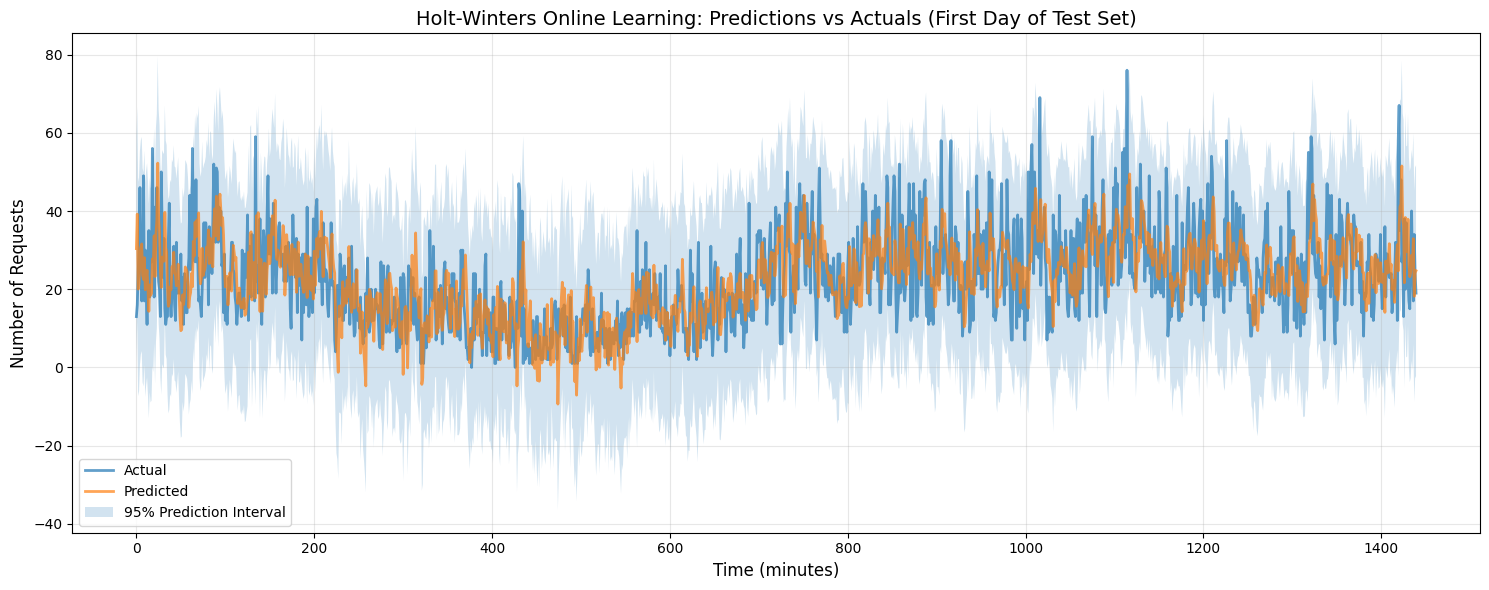

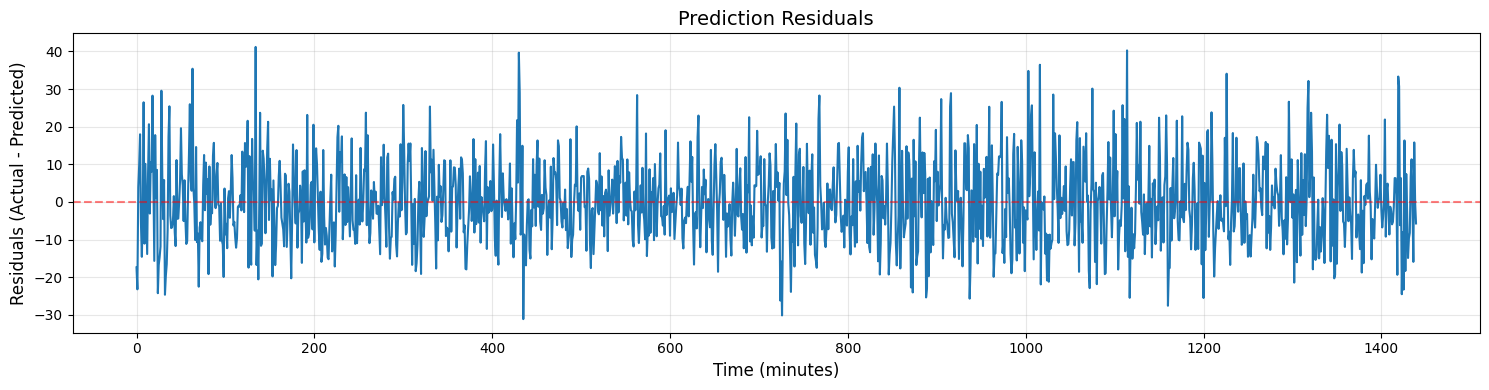

In [12]:
# Visualize results

# Plot a subset for clarity (first 1440 minutes = 1 day)
plot_samples = min(1440, len(test_dataset))

plt.figure(figsize=(15, 6))
plt.plot(range(plot_samples), actual_values[:plot_samples], label='Actual', linewidth=2, alpha=0.7)
plt.plot(range(plot_samples), predictions[:plot_samples], label='Predicted', linewidth=2, alpha=0.7)

# Plot prediction intervals
lower_bounds = [pi['lower_bound'] for pi in prediction_intervals[:plot_samples]]
upper_bounds = [pi['upper_bound'] for pi in prediction_intervals[:plot_samples]]
plt.fill_between(range(plot_samples), lower_bounds, upper_bounds, alpha=0.2, label='95% Prediction Interval')

plt.xlabel('Time (minutes)', fontsize=12)
plt.ylabel('Number of Requests', fontsize=12)
plt.title('Holt-Winters Online Learning: Predictions vs Actuals (First Day of Test Set)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot residuals
residuals = actual_values[:plot_samples] - predictions[:plot_samples]
plt.figure(figsize=(15, 4))
plt.plot(range(plot_samples), residuals)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.xlabel('Time (minutes)', fontsize=12)
plt.ylabel('Residuals (Actual - Predicted)', fontsize=12)
plt.title('Prediction Residuals', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()